# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
initial_df = pd.read_csv(r'C:\Users\Fahim\Yr3-Project-1\Python import.csv')

**Data exploration**

In [232]:
#print(initial_df.head())
#print(initial_df.columns)
#print(initial_df.describe())
#print(initial_df.info())

Index(['Catalyst Materials', 'Family', 'Substrate',
       'Operating Conditions (T, pH, potential)', 'Valence state, A',
       'Valence state, B', 'Ionic radius A', 'Ionic radius B', 'ΔGOH*', 'ΔGO*',
       'ΔGOOH*', 'Adsorption strength', 'Stable hours/cycles',
       'Tafel Slope, mV per decade',
       'Overpotential at xx (nearby) current density vs RHE, V',
       'Reaction (HER, HRR, OER, ORR)'],
      dtype='object')


**Data cleaning**

In [223]:
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [230]:
initial_df = parse_Nan(initial_df)
entropy_data = initial_df[["Catalyst Materials","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]]
columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
#print(entropy_data.describe())

C:\Users\Fahim\AppData\Local\Temp\ipykernel_23740\2717156615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
C:\Users\Fahim\AppData\Local\Temp\ipykernel_23740\2717156615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']


**Preparing first graph**

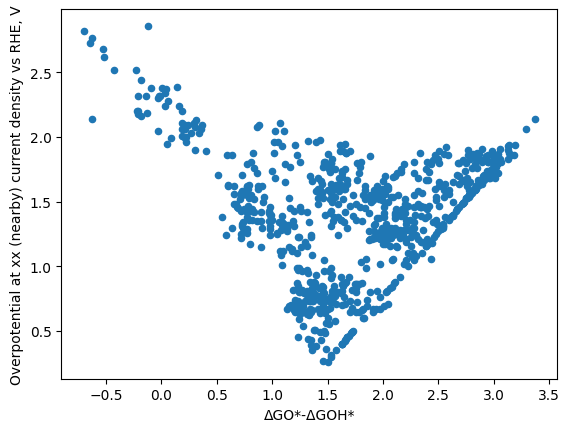

In [225]:
entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
#print(entropy_data)
entropy_data.plot(x='ΔGO*-ΔGOH*', y = 'Overpotential at xx (nearby) current density vs RHE, V', kind='scatter')
plt.show()

**Clustering**

In [226]:
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng,sse)
    plt.show()

In [227]:
def cluster_df(cluster_df):
    entropy_data_1= cluster_df[cluster_df.cluster==0]
    entropy_data_2= cluster_df[cluster_df.cluster==1]
    entropy_data_3= cluster_df[cluster_df.cluster==2]
    entropy_data_4= cluster_df[cluster_df.cluster==3]
    entropy_data_5= cluster_df[cluster_df.cluster==4]
    plt.scatter(entropy_data_1['ΔGO*-ΔGOH*'],entropy_data_1['Overpotential at xx (nearby) current density vs RHE, V'],color= 'green')
    plt.scatter(entropy_data_2['ΔGO*-ΔGOH*'],entropy_data_2['Overpotential at xx (nearby) current density vs RHE, V'],color= 'black')
    plt.scatter(entropy_data_3['ΔGO*-ΔGOH*'],entropy_data_3['Overpotential at xx (nearby) current density vs RHE, V'],color= 'red')
    plt.scatter(entropy_data_4['ΔGO*-ΔGOH*'],entropy_data_4['Overpotential at xx (nearby) current density vs RHE, V'],color= 'yellow')
    plt.scatter(entropy_data_5['ΔGO*-ΔGOH*'],entropy_data_5['Overpotential at xx (nearby) current density vs RHE, V'],color= 'purple')
    return entropy_data_1,entropy_data_2,entropy_data_3,entropy_data_4,entropy_data_5

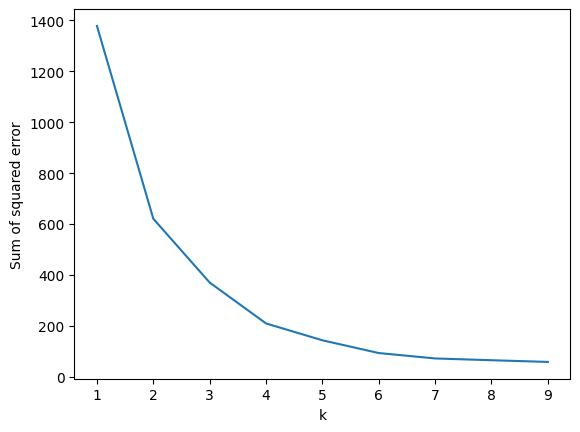

C:\Users\Fahim\AppData\Local\Temp\ipykernel_23740\385784569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entropy_data['cluster'] = y_predicted


  Catalyst Materials  ΔGOH*  ΔGO*  ΔGOOH*  \
0    (Mn-Co-Ta-Sb)Ox   0.00  0.00    0.00   
1         [Mo2S12]2-   0.00  0.00    0.00   
2            1T-MoS2   0.00  0.00    0.00   
3             AgAlO3   2.18  4.63    5.10   
4             AgBiO3   1.09  3.37    4.23   

   Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  cluster  
0                                               0.55             0.00        1  
1                                               0.00             0.00        1  
2                                               0.42             0.00        1  
3                                               1.82             2.45        4  
4                                               1.55             2.28        0  


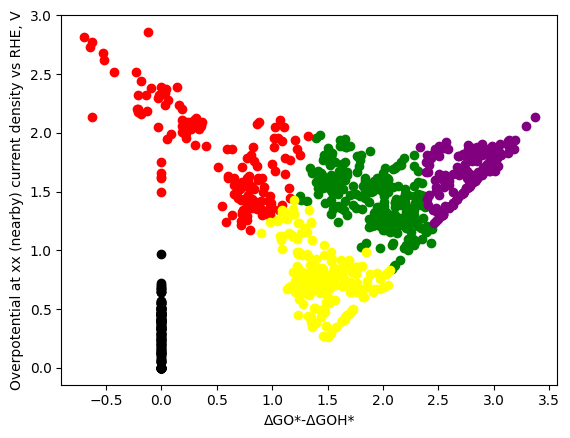

In [231]:
elbow_plot(entropy_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(entropy_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
entropy_data['cluster'] = y_predicted
cluster_df(entropy_data)
plt.xlabel('ΔGO*-ΔGOH*')
plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
print(entropy_data.head())